In [1]:
!pip install --no-cache-dir lightning torchmetrics moviepy av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 195.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 188.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 158.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 146.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 128.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 248.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 155.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 164.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 175.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 202.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 168.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

from google.colab.patches import cv2_imshow
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import av
import torchvision

from torchvision.models import mnasnet0_5, MNASNet0_5_Weights
from torchvision.transforms import Compose
from torchvision.datasets import HMDB51
from torchvision.datasets.utils import download_url

import imageio.v2 as imageio
from moviepy.editor import VideoFileClip

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

  if event.key is 'enter':



In [3]:
FPS            = 2
MAX_CLIP_INFER = 4
NUM_FRAMES     = 8
BATCH_SIZE     = 16
REDUCE_RATIO   = 32
EPOCH          = 64
IMAGE_SIZE     = 128
EMBEDDING_DIM  = 256
HIDDEN_DIM     = 512

In [4]:
REDUCE_LR_FACTOR        = 1/2
EARLY_STOPPING_PATIENCE = 1/4
REDUCE_LR_PATIENCE      = 1/16
LEARNING_RATE           = 1/512

In [5]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [6]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 196378404


In [7]:
download_url(
    url=HMDB51.data_url,
    root="experiment/dataset",
    filename="hmdb51_org.rar",
)

download_url(
    url=HMDB51.splits["url"],
    root="experiment/dataset",
    filename="test_train_splits.rar",
    md5=HMDB51.splits["md5"],
)

100%|██████████| 2.12G/2.12G [01:07<00:00, 31.7MB/s]
100%|██████████| 200k/200k [00:00<00:00, 789kB/s]


In [8]:
# Extract and organize video data..
!mkdir -p experiment/dataset/video_data experiment/dataset/test_train_splits
!unrar e experiment/dataset/test_train_splits.rar experiment/dataset/test_train_splits
!rm experiment/dataset/test_train_splits.rar
!unrar e experiment/dataset/hmdb51_org.rar
!rm experiment/dataset/hmdb51_org.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from experiment/dataset/test_train_splits.rar

Extracting  experiment/dataset/test_train_splits/brush_hair_test_split1.txt       0%  OK 
Extracting  experiment/dataset/test_train_splits/brush_hair_test_split2.txt       1%  OK 
Extracting  experiment/dataset/test_train_splits/brush_hair_test_split3.txt       1%  OK 
Extracting  experiment/dataset/test_train_splits/cartwheel_test_split1.txt       2%  OK 
Extracting  experiment/dataset/test_train_splits/cartwheel_test_split2.txt       2%  OK 
Extracting  experiment/dataset/test_train_splits/cartwheel_test_split3.txt       3%  OK 
Extracting  experiment/dataset/test_train_splits/catch_test_split1.txt       4%  OK 
Extracting  experiment/dataset/test_train_splits/catch_test_split2.txt       4%  OK 
Extracting  experiment/dataset/test_train_splits/catch_test_split3.txt       5%

In [9]:
!mv *.rar experiment/dataset/video_data

for files in os.listdir('experiment/dataset/video_data'):
    foldername = files.split('.')[0]
    os.system("mkdir -p experiment/dataset/video_data/" + foldername)
    os.system(
        "unrar e experiment/dataset/video_data/" + files + " experiment/dataset/video_data/" + foldername
    )

!rm experiment/dataset/video_data/*.rar

In [10]:
def _is_tensor_video_clip(clip):
    if not torch.is_tensor(clip):
        raise TypeError("clip should be Tesnor. Got %s" % type(clip))

    if not clip.ndimension() == 4:
        raise ValueError("clip should be 4D. Got %dD" % clip.dim())

    return True


def resize(clip, target_size, interpolation_mode):
    assert len(target_size) == 2, "target size should be tuple (height, width)"
    return F.interpolate(clip, size=target_size, mode=interpolation_mode)


def to_tensor(clip):
    """
    Convert tensor data type from uint8 to float, divide value by 255.0 and
    permute the dimenions of clip tensor
    Args:
        clip (torch.tensor, dtype=torch.uint8): Size is (T, H, W, C)
    Return:
        clip (torch.tensor, dtype=torch.float): Size is (C, T, H, W)
    """
    _is_tensor_video_clip(clip)
    if not clip.dtype == torch.uint8:
        raise TypeError(
            "clip tensor should have data type uint8. Got %s" % str(clip.dtype)
        )
    return clip.float().permute(3, 0, 1, 2) / 255.0


class ToTensor(object):
    """
    Convert tensor data type from uint8 to float, divide value by 255.0 and
    permute the dimenions of clip tensor
    """

    def __init__(self):
        pass

    def __call__(self, clip):
        """
        Args:
            clip (torch.tensor, dtype=torch.uint8): Size is (T, H, W, C)
        Return:
            clip (torch.tensor, dtype=torch.float): Size is (C, T, H, W)
        """
        return to_tensor(clip)

    def __repr__(self):
        return self.__class__.__name__


class Resize(object):
    def __init__(self, size, interpolation_mode="bilinear"):
        self.size = size
        self.interpolation_mode = interpolation_mode

    def __call__(self, clip):
        return resize(clip, self.size, self.interpolation_mode)

    def __repr__(self):
        return self.__class__.__name__

In [11]:
CLASS_NAME = [
    "brush_hair",
    "cartwheel",
    "catch",
    "chew",
    "clap",
    "climb",
    "climb_stairs",
    "dive",
    "draw_sword",
    "dribble",
    "drink",
    "eat",
    "fall_floor",
    "fencing",
    "flic_flac",
    "golf",
    "handstand",
    "hit",
    "hug",
    "jump",
    "kick",
    "kick_ball",
    "kiss",
    "laugh",
    "pick",
    "pour",
    "pullup",
    "punch",
    "push",
    "pushup",
    "ride_bike",
    "ride_horse",
    "run",
    "shake_hands",
    "shoot_ball",
    "shoot_bow",
    "shoot_gun",
    "sit",
    "situp",
    "smile",
    "smoke",
    "somersault",
    "stand",
    "swing_baseball",
    "sword",
    "sword_exercise",
    "talk",
    "throw",
    "turn",
    "walk",
    "wave",
]

In [12]:
transform = Compose(
    [
        ToTensor(),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
    ]
)

In [13]:
!pip install -q av
import av
import torchvision

TrainDataset = HMDB51(
    'experiment/dataset/video_data/',
    'experiment/dataset/test_train_splits/',
    frames_per_clip=NUM_FRAMES,
    step_between_clips=NUM_FRAMES,
    frame_rate=FPS,
    fold=1,
    train=True,
    transform=transform,
)
ValDataset = HMDB51(
    'experiment/dataset/video_data/',
    'experiment/dataset/test_train_splits/',
    frames_per_clip=NUM_FRAMES,
    step_between_clips=NUM_FRAMES,
    frame_rate=FPS,
    fold=2,
    train=False,
    transform=transform,
)
TestDataset = HMDB51(
    'experiment/dataset/video_data/',
    'experiment/dataset/test_train_splits/',
    frames_per_clip=NUM_FRAMES,
    step_between_clips=NUM_FRAMES,
    frame_rate=FPS,
    fold=3,
    train=False,
    transform=transform,
)

100%|██████████| 423/423 [01:52<00:00,  3.78it/s]


In [14]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

In [15]:
class CNNBidirectionalRNN(nn.Module):
    def __init__(self):
        super(CNNBidirectionalRNN, self).__init__()

        self.cnn = mnasnet0_5(weights=MNASNet0_5_Weights.IMAGENET1K_V1)
        for param in self.cnn.layers.parameters():
            param.requires_grad = False
        self.cnn.classifier[1] = nn.Linear(
            1280,
            EMBEDDING_DIM,
            bias=True,
        )

        self.rnn_cell_forward = nn.RNNCell(EMBEDDING_DIM, HIDDEN_DIM, bias=True)
        self.rnn_cell_backward = nn.RNNCell(EMBEDDING_DIM, HIDDEN_DIM, bias=True)

        self.cnn_transition = nn.Sequential(
            nn.Conv1d(NUM_FRAMES, 1, 1, bias=False),
            nn.BatchNorm1d(1),
        )

        self.classifier = nn.Sequential(
            nn.Linear(2 * HIDDEN_DIM, (2 * HIDDEN_DIM) // REDUCE_RATIO, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear((2 * HIDDEN_DIM) // REDUCE_RATIO, len(CLASS_NAME), bias=True),
        )

    def forward(self, x):
        batch_size, channels, sequence_length, height, width = x.size()

        # Initialize hidden state
        h_forward = torch.zeros(batch_size, HIDDEN_DIM).to(x.device)
        h_backward = torch.zeros(batch_size, HIDDEN_DIM).to(x.device)

        # Lists to store outputs for each time step
        outputs_forward, outputs_backward = [], []

        # Process each time step in the sequence
        for t_forward in range(sequence_length):
            emb_forward = self.cnn(x[:, :, t_forward, :, :])
            h_forward = self.rnn_cell_forward(
                emb_forward,
                h_forward,
            )
            outputs_forward.append(h_forward)

            t_backward = (sequence_length - 1) - t_forward
            emb_backward = self.cnn(x[:, :, t_backward, :, :])
            h_backward = self.rnn_cell_backward(
                emb_backward,
                h_backward,
            )
            outputs_backward.insert(0, h_backward)  # Insert at the beginning

        # Concatenate forward and backward outputs along the feature dimension
        outputs = torch.cat(
            [
                torch.stack(outputs_forward, dim=0).permute(1, 0, 2),
                torch.stack(outputs_backward, dim=0).permute(1, 0, 2),
            ],
            dim=-1,
        )

        outputs = self.cnn_transition(outputs).squeeze(1)

        return self.classifier(outputs)

In [16]:
MODEL = CNNBidirectionalRNN
MODEL_NAME = MODEL.__name__
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR,f"{MODEL_NAME}_best.ckpt")

In [17]:
class ModelWrapper(L.LightningModule):
    def __init__(self):
        super().__init__()

        num_classes = len(CLASS_NAME)

        self.arch = MODEL()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):
        x, _, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)
        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, _, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            sch = self.lr_schedulers()
            sch.step(acc)
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now > lr_now_:
                self.lr_now = lr_now_
                print(
                    f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_} - Epoch: {self.current_epoch}"
                )
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, _, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = f"experiment/training/{MODEL_NAME}_acc_plot.png"
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max",
                factor=REDUCE_LR_FACTOR,
                patience=int(math.ceil(REDUCE_LR_PATIENCE * self.max_epoch)),
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

INFO: Seed set to 196378404
INFO:lightning.fabric.utilities.seed:Seed set to 196378404
Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to /root/.cache/torch/hub/checkpoints/mnasnet0.5_top1_67.823-3ffadce67e.pth
100%|██████████| 8.59M/8.59M [00:00<00:00, 53.5MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


CNNBidirectionalRNN


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | arch           | CNNBidirectionalRNN | 2.1 M  | train
1 | train_accuracy | MulticlassAccuracy  | 0      | train
2 | val_accuracy   | MulticlassAccuracy  | 0      | train
3 | test_accuracy  | MulticlassAccuracy  | 0      | train
---------------------------------------------------------------
1.2 M     Trainable params
937 K     Non-trainable params
2.1 M     Total params
8.354     Total estimated model params size (MB)
195       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | arch           | CNNBidirectionalRNN | 2.1 M  | train
1 | train_accuracy | Mu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[CNNBidirectionalRNN] Learning Rate Changed: 0.001953125 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[CNNBidirectionalRNN] Learning Rate Changed: 0.0009765625 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=64` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=64` reached.


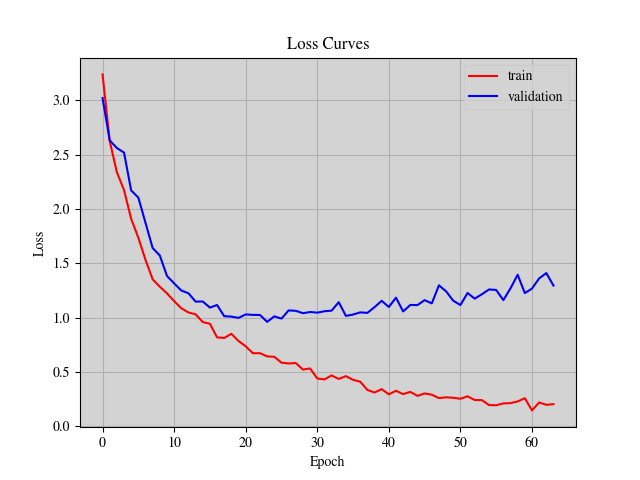

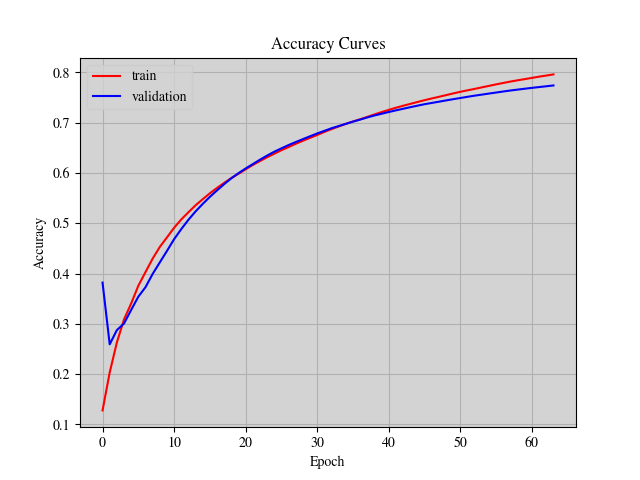

<Figure size 640x480 with 0 Axes>

In [18]:
def _train_loop():
    seed_everything(SEED, workers=True)

    model = ModelWrapper()

    checkpoint = ModelCheckpoint(
        monitor='val_acc',
        dirpath=EXPERIMENT_DIR,
        mode='max',
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_acc",
        min_delta=0.00,
        patience=int(EARLY_STOPPING_PATIENCE * EPOCH),
        verbose=False,
        mode="max",
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

In [19]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = ModelWrapper()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/CNNBidirectionalRNN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the c

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9261540770530701     │
│         test_loss         │    0.6994895339012146     │
└───────────────────────────┴───────────────────────────┘

In [20]:
model = ModelWrapper.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

InferenceDataset = HMDB51(
    'experiment/dataset/video_data/',
    'experiment/dataset/test_train_splits/',
    frames_per_clip=NUM_FRAMES,
    step_between_clips=NUM_FRAMES,
    frame_rate=FPS,
    fold=1,
    train=False,
    transform=transform,
)
InferenceLoader = data.DataLoader(
    dataset=InferenceDataset,
    batch_size=1,
    shuffle=True,
    drop_last=True,
)

100%|██████████| 423/423 [01:56<00:00,  3.62it/s]


MoviePy - Building file experiment/result.gif with imageio.


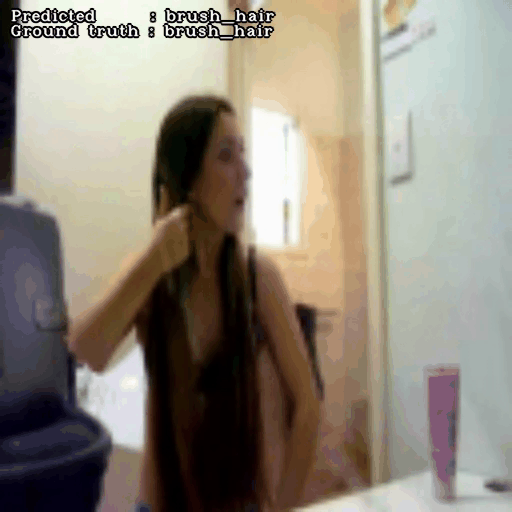

In [21]:
video_frames = list()

colors = [(0, 0, 0), (255, 255, 255)]
thickness = [3, 1]
origin = [(10, 20), (10, 35)]

clip_count = 0
class_bin = list()

for idx, batch in enumerate(InferenceLoader):
    if clip_count > MAX_CLIP_INFER:
        break

    x, _, y = batch
    y_hat = model(
        x.to(
            "cpu" if not torch.cuda.is_available() else "cuda"
        )
    ).softmax(1).view(-1)

    sequence_length = x.shape[2]

    predicted_class = CLASS_NAME[torch.argmax(y_hat).data.cpu().numpy()]
    gt_class = CLASS_NAME[y.view(-1).data.cpu().numpy()[0]]

    if predicted_class != gt_class:
        continue

    if predicted_class in class_bin:
        continue
    else:
        class_bin.append(predicted_class)

    clip_count += 1

    for frame_idx in range(sequence_length):
        frame = x[:, :, frame_idx, :, :] * 255.
        frame = frame.squeeze(0).permute(1, 2, 0).cpu().data.numpy()
        frame = frame.astype(np.uint8).copy()
        frame = cv2.resize(frame, (4 * IMAGE_SIZE, 4 * IMAGE_SIZE))

        for text, orig in zip(
            [
                f"Predicted      : {predicted_class}",
                f"Ground truth : {gt_class}",
            ],
            origin
        ):
            for color, thick in zip(colors, thickness):
                frame = cv2.putText(
                    frame,
                    text,
                    orig,
                    cv2.FONT_HERSHEY_COMPLEX_SMALL,
                    0.75,
                    color,
                    thick,
                    cv2.LINE_AA,
                )

        video_frames.append(frame)


video_path = "experiment/result.mp4"
imageio.mimwrite(
    video_path,
    video_frames,
    fps=1/FPS,
    quality=7,
    macro_block_size=None,
)
videoClip = VideoFileClip(video_path)
videoClip.set_fps(1/FPS)
videoClip.write_gif("experiment/result.gif")
with open("experiment/result.gif", "rb") as f:
    display(Image(data=f.read(), format="gif"))

In [22]:
torch.save(model, 'emotion_model.pth')